In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, sqrt
import sys

TOL = sys.float_info.epsilon
print(TOL)

2.220446049250313e-16


In [2]:
def vetor(x,y,z):
    return np.array([x,y,z],dtype=np.float64)

def ang(v1,v2):
    num = dot(v1,v2)
    den = norm(v1)*norm(v2)
    return np.arccos(num/den)*180/np.pi if den>TOL else 0

def norma(v):
    return sqrt(v[0]*v[0]+v[1]*v[1]+v[2]*v[2])

def unitario(v):
    s = norma(v)
    if (s>TOL):
        return v/s
    else:
        return None
def dot(u,v):
    return u[0]*v[0]+u[1]*v[1]+u[2]*v[2]

def reflete(v,n):
    r = 2*dot(v,n)*n-v
    return r

def cross(u,v):
    return vetor( u[1]*v[2] - u[2]*v[1] , u[2]*v[0] - u[0]*v[2] , u[0]*v[1] - u[1]*v[0])

In [3]:
class Camera:
    def __init__(self,fov,w,h,dfocal,eye,at,up):
        self.fov = fov
        self.w = w
        self.h = h
        self.dfocal = dfocal
        self.a = 2*dfocal*np.tan(fov*np.pi/360)
        self.b = self.a*w/h
        self.eye = eye
        self.ze = unitario(at-eye)
        self.xe = unitario(cross(self.ze,up))
        self.ye = cross(self.ze,self.xe)
        self.img = np.full((h,w,3),0.43,dtype=np.float64)
        
    def show(self):
        print("CAMERA")
        print(f'fov={self.fov}, d={self.dfocal}')
        print(f'(w,h)=({self.w},{self.h})')
        print(f'(b,a)=({self.b},{self.a})')
        print(f'xe={self.xe}')
        print(f'ye={self.ye}')
        print(f'ze={self.ze}')

    def ray_to(self,x,y):
        dx = self.b*(x/self.w-0.5)
        dy = self.a*(y/self.h-0.5)
        dz = self.dfocal
        ray = dx*self.xe+dy*self.ye+dz*self.ze
        return ray

    def get_eye(self):
        return self.eye

    def get_pixel(self,x,y):
        return self.img[y,x,:]

    def set_pixel(self,x,y,rgb):
        self.img[y,x,:]=rgb

    def add_pixel(self,x,y,rgb):
        self.img[y,x,:]+=rgb

    def get_w(self):
        return self.w

    def get_h(self):
        return self.h

    def imshow(self):
        img_max = np.amax(self.img)
        if img_max < TOL:
            print("Imagem Zerada")
        self.img = self.img/img_max
        plt.imshow(self.img)
        plt.show()
    

In [4]:
class Poligono:
    def __init__(self,pp,pn,material):
        self.pp=pp
        self.pn=pn
        self.ni=None
        self.material=material

    def show(self):
        for i in range(len(self.pp)):
            print(f'plano{i}: ponto={self.pp[i]}, normal={self.pn[i]}')
    
    def intercepta(self,origem,direcao):
        te=0
        ts=np.inf
        obji=None
        return te,obji
        for i in range(len(self.pp)):
            pn = self.pn[i]
            pp = self.pp[i]
            num = dot(pp-origem,pn)
            den = dot(direcao,pn)
            if den<-TOL:
                t = num/den
                if t>te:
                    te=t
                    obji=self
                    self.ni= pn
            elif den>TOL:
                t = num/den
                ts = t if t<ts else ts
            if ts<te:
                te = np.inf
                obji = None
                break
        return te,obji
    
    def get_material(self):
        return self.material
    
    def normal(self,ponto):
        return self.ni

In [5]:
class Caixa(Poligono):
    def __init__(self,pmin,pmax,material):
        super().__init__( [pmin,pmin,pmin,pmax,pmax,pmax],
                         [vetor(-1,0,0),vetor(0,-1,0),vetor(0,0,-1),
                         vetor(1,0,0),vetor(0,1,0),vetor(0,0,1)], material )
        

In [6]:
class Esfera:
    def __init__(self,raio,centro,material):
        self.raio = raio
        self.centro = centro
        self.material = material
        
    def show(self):
        print("Esfera")
        print(f' raio={self.raio}')
        print(f' centro={self.centro}')
        self.material.show()
        
    def intercepta(self,origem,direcao):
        a = dot(direcao,direcao)
        b = 2*dot(direcao,origem-self.centro)
        c = dot(origem-self.centro,origem-self.centro)-self.raio**2
        delta = b**2 - 4*a*c
        if delta>TOL:
            raiz = sqrt(delta)
            t1 = (-b-raiz)/(2*a)
            t2 = (-b+raiz)/(2*a)
            t = t1 if t1<t2 else t2
            if t>0:
                return t,self
            else:
                return np.inf, None
        else:
            return np.inf, None
        
    def normal(self,ponto):
        return (ponto - self.centro)/self.raio
    
    def get_material(self):
        return self.material

In [7]:
class Material:
    def __init__(self,kd,ks,ns,espelhamento,opacidade,textura):
        self.kd=kd
        self.ks=ks
        self.ns=ns
        self.espelhamento=espelhamento
        self.opacidade=opacidade
        if textura is not None:
            img = plt.imread(textura)
            img = img/255
            img = img[:,:,:3]
            self.textura = img
        else:
            self.textura = None

        def show(self):
            print("Material:")
            print("cor difuso=",self.kd)
            print("cor especular=",self.ks)
            print("coeficiente especular=",self.ns)
            print("espelhamento = ",self.espelhamento)
            print("opacidade = ",self.opacidade)
            
        def get_Phong(self,u,v):
            if self.textura is None:
                return self.kd,self.ks,self.ns
            else:
                ht,wt = self.textura.shape
                x = int(u*wt)
                y = int(v*ht)
                kd = self.textura[y,x,:]
                return kd,self.ks,self.ns
        
        def get_espelhamento(self):
            return self.espelhamento
        
        def get_opacidade(self):
            return self.opacidade

In [8]:
class Luz:
    def __init__(self,posicao,intensidade):
        self.posicao = posicao
        self.intensidade = intensidade
    
    def show(self):
        print("Luz")
        print(f'posicao = {self.posicao}')
        print(f'intensidade = {self.intensidade}')
        
    def get_pos(self):
        return self.posicao
    
    def get_intensidade(self):
        return self.intensidade

In [9]:
class Cena:
    def __init__(self,camera,objetos,materiais,ambiente,luzes):
        self.camera = camera
        self.objetos = objetos
        self.materiais = materiais
        self.ambiente = ambiente
        self.luzes = luzes
        
    def show(self):
        self.camera.show()
        for obj in self.objetos:
            obj.show()
        for mat in self.materiais:
            mat.show()
        print("ambiente =",self.ambiente)
        for luz in self.luzes:
            luz.show()
        
    def render(self):
        w = self.camera.get_w()
        h = self.camera.get_h()
        origem = self.camera.get_eye()
        for y in range(h):
            for x in range(w):
                direcao = self.camera.ray_to(x,y)
                rgb, obji = self.trace(None,origem,direcao,0)
                if obji is not None:
                    self.camera.set_pixel(x,y,rgb)

    def trace(self,objeto,origem,direcao,nrec):
        ti = np.inf
        obji = None
        for obj in self.objetos:
            if obj is not objeto:
                t, objx = obj.intercepta(origem,direcao)
                if t<ti:
                    ti=t
                    obji=objx
        if obji and ti>TOL:
            ponto = origem+ti*direcao
            rgb = self.shade(obji,origem,ponto,nrec)
            return rgb,obji
        return None,None
    
    def shade(self,objeto,origem,ponto,nrec):
        material = objeto.get_material()
        normal = objeto.normal(ponto)
        u,v = objeto.get_texture(ponto)
        kd,ks,ns = material.get_Phong(u,v)
        cor = self.ambiente*kd
        toEye = unitario(origem - ponto)
        for luz in self.luzes:
            toLuz = luz.get_pos()-ponto
            naSombra = self.sombra(objeto,ponto,toLuz)
            if naSombra is False:
                vluz = unitario(toLuz)
                cos1 = dot(vluz,normal)
                if cos1>TOL:
                    Lw = luz.get_intensidade()
                    cor+= Lw*kd*cos1
                    rluz=reflete(vluz,normal)
                    cos2 = dot(rluz,toEye)
                    if cos2>TOL:
                        cor+=Lw*ks*(cos2**ns)
        espelhamento = material.get_espelhamento()
        if espelhamento>0 and nrec < 5:
            dir_espelhada= reflete(toEye,normal)
            rgb_espelhado, obji = self,trace(objeto,ponto,dir_espelhada,nrec+1)
            if obji is not None:
                cor = (1-espelhamento)*cor+espelhamento*rgb_espelhado
            else:
                cor=(1-espelhamento)*cor
        return cor
    
    def sombra(self,objeto,origem,direcao):
        ti=np.inf
        obji=None
        for obj in self.objetos:
            if obj is not objeto:
                t,objx=obj.intercepta(origem,direcao)
                if t>TOL and t<1:
                    return True
        return False

In [10]:
eye = vetor(100,40,40)
at = vetor(0,0,0)
up = vetor(0,1,0)
camera = Camera(90,300,300,30,eye,at,up)
camera.show()

CAMERA
fov=90, d=30
(w,h)=(300,300)
(b,a)=(59.999999999999986,59.99999999999999)
xe=[ 0.37139068  0.         -0.92847669]
ye=[ 0.32325409 -0.93743687  0.12930164]
ze=[-0.87038828 -0.34815531 -0.34815531]


In [11]:
luz = Luz(vetor(60.,120.,40.),vetor(0.8,0.8,0.8))
luz2 = Luz(vetor(100.,40.,40.),vetor(0.8,0.8,0.8))
luz.show()

Luz
posicao = [ 60. 120.  40.]
intensidade = [0.8 0.8 0.8]


In [12]:
azul_metalico = Material(vetor(0,0,1),vetor(1,1,1),30,0,1,"formica.png")
amarelo_fosco = Material(vetor(0.7,0.7,0),vetor(0,0,0),1,0,1,None)
amarelo_espelho = Material(vetor(0.7,0.7,0),vetor(0,0,0),1,1,1,None)

In [13]:
esfera = Esfera(25,vetor(0,20,0),azul_metalico)
#esfera.show()

In [14]:
piso = Caixa(vetor(-80,-50,-50),vetor(50,-45,50),amarelo_fosco)
parede = Caixa(vetor(-80,-50,-60),vetor(50,50,-50),amarelo_espelho)
piso.show()
parede.show()

plano0: ponto=[-80. -50. -50.], normal=[-1.  0.  0.]
plano1: ponto=[-80. -50. -50.], normal=[ 0. -1.  0.]
plano2: ponto=[-80. -50. -50.], normal=[ 0.  0. -1.]
plano3: ponto=[ 50. -45.  50.], normal=[1. 0. 0.]
plano4: ponto=[ 50. -45.  50.], normal=[0. 1. 0.]
plano5: ponto=[ 50. -45.  50.], normal=[0. 0. 1.]
plano0: ponto=[-80. -50. -60.], normal=[-1.  0.  0.]
plano1: ponto=[-80. -50. -60.], normal=[ 0. -1.  0.]
plano2: ponto=[-80. -50. -60.], normal=[ 0.  0. -1.]
plano3: ponto=[ 50.  50. -50.], normal=[1. 0. 0.]
plano4: ponto=[ 50.  50. -50.], normal=[0. 1. 0.]
plano5: ponto=[ 50.  50. -50.], normal=[0. 0. 1.]


In [15]:
objetos = [esfera,piso,parede]
materiais = [azul_metalico, amarelo_fosco,amarelo_espelho]
luzes=[luz,luz2]
ambiente = vetor(0.1,0.1,0.1)
cena = Cena(camera,objetos,materiais,ambiente,luzes)
# cena.show()

In [16]:
cena.render()

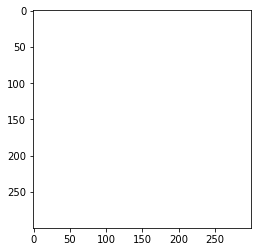

In [17]:
camera.imshow()